In [3]:
%load_ext autoreload 

In [2]:
import sys
sys.path.insert(0, '../lib')
# from CNN import CNN

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [136]:
class CNN(nn.Module):
    def __init__(self, img_shape = 28, conv_layers = 2, num_classes = 10):
        super(CNN, self).__init__()
        
#         self.conv_count = 0   #keeps track of the number of times a conv layer is added
        self.img_shape = img_shape   
        self.num_classes = num_classes
        self.conv_layers = conv_layers
        self.root_path = '../data/28x28'
        self.ker_size = 0
        self.padding = 0
        self.out_channels = 0
        self.linear_shape = [1, img_shape, img_shape]
        self.conv = []
        
        
        def conv_out_size(linear_shape, img_shape, conv):
            linear_shape[0] = conv[0].out_channels
            linear_shape[1] = int(( (img_shape - conv[0].kernel_size[0] + 2*conv[0].padding[0]) / conv[0].stride[0]) + 1)
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape


        def pooling_out_size(linear_shape, img_shape, conv):
            linear_shape[1] = int(( (img_shape - conv[2].kernel_size) / conv[2].stride) + 1)
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape

        def flatten(linear_shape):
            return linear_shape[0] * linear_shape[1] * linear_shape[2]
        
        
        def load_data(img_shape, root_path):
            train_data = datasets.MNIST(
                root = root_path,
                train = True,                         
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(img_shape),
                                transforms.Normalize(0, 1)
                            ]), 
                download = False,            
            )
            test_data = datasets.MNIST(
                root = '../data/28x28', 
                train = False, 
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(img_shape),
                                transforms.Normalize(0, 1)
                            ]) 
            )
            
            return train_data, test_data
        
        
        # Loading training and testing data
        self.train_data, self.test_data = load_data(self.img_shape, self.root_path)
        
        self.loaders = {
            'train' : torch.utils.data.DataLoader(self.train_data, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),

            'test'  : torch.utils.data.DataLoader(self.test_data, 
                                                  batch_size=100, 
                                                  shuffle=True, 
                                                  num_workers=1),
        }
        
        if self.img_shape == 28:
            self.out_channels = 16
            self.ker_size = 5
        
        elif self.img_shape == 14:
            self.out_channels = 8
            self.ker_size = 3
            
        elif self.img_shape == 7:
            self.out_channels = 4
            self.ker_size = 2
            
        elif self.img_shape == 4:
            self.out_channels = 4
            self.ker_size = 3
            self.padding = 1
        
        for i in range(conv_layers):
#             ker_size = 5
#             padding = 0
            if not self.conv:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels=1,              
                        out_channels=self.out_channels,            
                        kernel_size=self.ker_size,              
                        stride=1,                   
                        padding=self.padding,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
                
            else:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels = self.conv[i-1][0].out_channels,              
                        out_channels = self.conv[i-1][0].out_channels * 2,            
                        kernel_size = self.ker_size,              
                        stride = 1,                   
                        padding=self.padding,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
            
            self.conv.append(layer)
#             self.conv_count += 1
            
            self.linear_shape, self.img_shape = conv_out_size(self.linear_shape, self.img_shape, self.conv[i])
            self.linear_shape, self.img_shape = pooling_out_size(self.linear_shape, self.img_shape, self.conv[i])
            
#             if self.img_shape <= 0 and self.ker_size >= 2:
#                 self.ker_size -= 1
#                 i = -1
#                 self.img_shape = img_shape
#                 print("executed!!")
            
#             print("ker_size = ", self.ker_size)
            
#             elif img_shape == 0 and padding == 0:
#                 padding += 1
#                 i = -1
#                 self.img_shape = img_shape
#                 print(img_shape)
            
            continue
        
        # input to Linear layer MUST be an integer!!
        self.out_shape = int(flatten(self.linear_shape))
        self.out = nn.Linear(self.out_shape, self.num_classes)
        
        
        
        
        
    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.conv[i](x)
            
        # flatten the output of conv2 to (batch_size, 32 * 4 * 4)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
    

def train(cnn, loaders, num_epochs=10):
    loss_func = nn.CrossEntropyLoss()   
    optimizer = torch.optim.Adam(cnn.parameters(), lr= 1e-5)
    
    cnn.train()
    
    train_acc_data = []
    loss_data = []
    # Train the model
    total_step = len(loaders['train'])    
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # measure accuracy and record loss
            train_output, last_layer = cnn(images)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))
                
            if (i+1) % 600 == 0:
                train_acc_data.append(accuracy)
                loss_data.append(loss)
            pass
        
        pass
    
    
    pass





In [139]:
cnn = CNN(img_shape=28)
print(cnn.out)
print(cnn.img_shape)

Linear(in_features=512, out_features=10, bias=True)
4


In [140]:
%%time
train_model(cnn, cnn.loaders)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [1/10], Step [100/600], Loss: 2.3014, Accuracy: 0.1700
Epoch [1/10], Step [200/600], Loss: 2.2899, Accuracy: 0.2000
Epoch [1/10], Step [300/600], Loss: 2.2859, Accuracy: 0.1900
Epoch [1/10], Step [400/600], Loss: 2.2777, Accuracy: 0.1600


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [1/10], Step [500/600], Loss: 2.2627, Accuracy: 0.2300
Epoch [1/10], Step [600/600], Loss: 2.2654, Accuracy: 0.2600


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [2/10], Step [100/600], Loss: 2.2561, Accuracy: 0.2900
Epoch [2/10], Step [200/600], Loss: 2.2396, Accuracy: 0.4200
Epoch [2/10], Step [300/600], Loss: 2.2311, Accuracy: 0.3900
Epoch [2/10], Step [400/600], Loss: 2.2347, Accuracy: 0.3700


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [2/10], Step [500/600], Loss: 2.2168, Accuracy: 0.5100
Epoch [2/10], Step [600/600], Loss: 2.2004, Accuracy: 0.5700


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [3/10], Step [100/600], Loss: 2.2011, Accuracy: 0.5200
Epoch [3/10], Step [200/600], Loss: 2.2014, Accuracy: 0.4900
Epoch [3/10], Step [300/600], Loss: 2.1935, Accuracy: 0.5200
Epoch [3/10], Step [400/600], Loss: 2.1970, Accuracy: 0.5500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [3/10], Step [500/600], Loss: 2.1795, Accuracy: 0.5900
Epoch [3/10], Step [600/600], Loss: 2.1617, Accuracy: 0.5800


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [4/10], Step [100/600], Loss: 2.1579, Accuracy: 0.6400
Epoch [4/10], Step [200/600], Loss: 2.1575, Accuracy: 0.6600
Epoch [4/10], Step [300/600], Loss: 2.1451, Accuracy: 0.6600
Epoch [4/10], Step [400/600], Loss: 2.1517, Accuracy: 0.5900


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [4/10], Step [500/600], Loss: 2.1173, Accuracy: 0.7100
Epoch [4/10], Step [600/600], Loss: 2.1146, Accuracy: 0.7100


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [5/10], Step [100/600], Loss: 2.1127, Accuracy: 0.7100
Epoch [5/10], Step [200/600], Loss: 2.1058, Accuracy: 0.7200
Epoch [5/10], Step [300/600], Loss: 2.1070, Accuracy: 0.6900
Epoch [5/10], Step [400/600], Loss: 2.0773, Accuracy: 0.7300


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [5/10], Step [500/600], Loss: 2.0829, Accuracy: 0.6800
Epoch [5/10], Step [600/600], Loss: 2.0817, Accuracy: 0.7000


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [6/10], Step [100/600], Loss: 2.0672, Accuracy: 0.6900
Epoch [6/10], Step [200/600], Loss: 2.0546, Accuracy: 0.7400
Epoch [6/10], Step [300/600], Loss: 2.0435, Accuracy: 0.7200
Epoch [6/10], Step [400/600], Loss: 2.0479, Accuracy: 0.7500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [6/10], Step [500/600], Loss: 2.0481, Accuracy: 0.7600
Epoch [6/10], Step [600/600], Loss: 2.0047, Accuracy: 0.7900


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [7/10], Step [100/600], Loss: 2.0463, Accuracy: 0.7300
Epoch [7/10], Step [200/600], Loss: 2.0207, Accuracy: 0.7400
Epoch [7/10], Step [300/600], Loss: 1.9818, Accuracy: 0.7900
Epoch [7/10], Step [400/600], Loss: 1.9924, Accuracy: 0.7900


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [7/10], Step [500/600], Loss: 2.0232, Accuracy: 0.6900
Epoch [7/10], Step [600/600], Loss: 1.9762, Accuracy: 0.7400


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [8/10], Step [100/600], Loss: 1.9973, Accuracy: 0.7300
Epoch [8/10], Step [200/600], Loss: 1.9680, Accuracy: 0.7900
Epoch [8/10], Step [300/600], Loss: 1.9553, Accuracy: 0.7600
Epoch [8/10], Step [400/600], Loss: 1.9306, Accuracy: 0.8200


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [8/10], Step [500/600], Loss: 1.9238, Accuracy: 0.7900
Epoch [8/10], Step [600/600], Loss: 1.9880, Accuracy: 0.6300


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [9/10], Step [100/600], Loss: 1.9090, Accuracy: 0.7600
Epoch [9/10], Step [200/600], Loss: 1.9484, Accuracy: 0.7700
Epoch [9/10], Step [300/600], Loss: 1.9319, Accuracy: 0.7500
Epoch [9/10], Step [400/600], Loss: 1.8961, Accuracy: 0.7700


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [9/10], Step [500/600], Loss: 1.8705, Accuracy: 0.8400
Epoch [9/10], Step [600/600], Loss: 1.8989, Accuracy: 0.7700


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee166c1860>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [10/10], Step [100/600], Loss: 1.9344, Accuracy: 0.7400
Epoch [10/10], Step [200/600], Loss: 1.9237, Accuracy: 0.6800
Epoch [10/10], Step [300/600], Loss: 1.8913, Accuracy: 0.7800
Epoch [10/10], Step [400/600], Loss: 1.8942, Accuracy: 0.7500


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fee3b6a0898>>
Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [10/10], Step [500/600], Loss: 1.8518, Accuracy: 0.8100
Epoch [10/10], Step [600/600], Loss: 1.8455, Accuracy: 0.7500
CPU times: user 4min 2s, sys: 25.1 s, total: 4min 27s
Wall time: 3min 43s


In [10]:
# There was something Jocelyn did to modify the image sizes without modifying the dtype
size = [28, 14, 7, 4]
train_data = [None] * 4
test_data = [None] * 4

for i in range(len(train_data)):
    train_data[i] = datasets.MNIST(
        root = '../data/4x4',
        train = True,                         
        transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(size[i]),
                        transforms.Normalize(0, 1)
                    ]), 
        download = False,            
    )
    test_data[i] = datasets.MNIST(
        root = '../data/4x4', 
        train = False, 
        transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(size[i]),
                        transforms.Normalize(0, 1)
                    ]),
        download = False,
    )

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


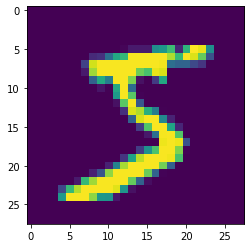

In [3]:
plt.imshow(train_data[0][0][0][0])

<h3>MNIST Dataset is organized by:</h3>
<div>Set of images (with channels) and labels --> train_data</div>
<div>image (with channels) AND label --> train_data[i (0,59999)]</div>
<div>image (with channels) --> train_data[i][i (0,1)]</div>
<div>image by itself (2D image) --> train_data[i][i][i (0)]</div>

In [4]:
# Images and labels are stored as a tuple (image, label)

print(len(train_data[0]), '\n\n')
print(train_data[0])

60000 


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/4x4
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=0, std=1)
           )


In [5]:
train_data[0]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/4x4
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=0, std=1)
           )

In [31]:
# train_data[0][0]

In [32]:
# Prints the entire dataset
# train_data[0][0].shape

In [33]:
# Prints one image
# train_data[0][0][0]

In [34]:
# Prints one array of pixels (not the entire image)
# train_data[0][0][0][0]

In [12]:
# plt.imshow(train_data[1][0][0])

<h1>Using Pytorch's Data loaders to feed data into CNN</h1>

In [9]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

NameError: name 'train_data' is not defined

In [ ]:
# experimenting
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

<h1>Defining the models</h1>

In [15]:
cnn = []

for i in range(len(size)):
    cnn.append(CNN(size[i]))

In [17]:
# print(cnn[0])

In [23]:
optimizer = []
loss_func = nn.CrossEntropyLoss()   

for i in range(len(cnn)):
    optimizer.append( torch.optim.Adam(cnn[i].parameters(), lr= 1e-5) )

# print(loss_func)
# print(optimizer)

<h1>Training the CNN</h1>
<div>Error source may be that the dataset resized_28 doesn't have 'labels', just 'images' ---> (for i, (images, labels))</div>

In [24]:
num_epochs = [75, 75, 125, 200]
train_acc_data = []
test_acc_data = []
loss_data = []

In [30]:
loaders['train']

torch.utils.data.dataloader.DataLoader

In [25]:
def train(num_epochs, cnn, loaders):
    for j in range(len(cnn)):
        cnn[j].train()

        # Train the model
        total_step = len(loaders['train'])

        for epoch in range(num_epochs[j]):
            for i, (images, labels) in enumerate(loaders['train']):

                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y
                output = cnn[j](b_x)[0]               
                loss = loss_func(output, b_y)

                # measure accuracy and record loss
                train_output, last_layer = cnn[j](images)
                pred_y = torch.max(train_output, 1)[1].data.squeeze()
                accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

                # clear gradients for this training step   
                optimizer.zero_grad()           

                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()  
    #             output = cnn(images)
    #             correct += (output == labels).float().sum()
    #             accuracy = 100 * correct / len(trainset)

                if (i+1) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}' 
                           .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))

                if(i+1) % 600 == 0:
                    train_acc_data.append(accuracy)
                    loss_data.append(loss)

                pass

            pass


        pass

def test():
    for j in range(len(cnn)):
        cnn[j].eval()

        # Train the model
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn[j](images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            test_acc_data.append(accuracy)
            print("Accuracy: {:.4f}".format(accuracy))

    #     print('Test Accuracy: %.2f' % accuracy)

In [26]:
train(num_epochs, cnn, loaders)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 86, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found torchvision.datasets.mnist.MNIST


In [ ]:
test()

In [ ]:
# for i in range(len(acc_data)):
#     if acc_data[i] == 0.71:
#         print("fount at ", i)

# acc_data[600-1]

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(20, 5))
axarr[0].set_title("Train Accuracy")
axarr[0].set_xlabel("Epochs")
axarr[0].set_ylabel("Accuracy")
axarr[0].plot(train_acc_data)

axarr[1].set_title("Test Accuracy")
axarr[1].set_xlabel("Batch #")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(test_acc_data)


axarr[2].set_title("Loss")
axarr[2].set_xlabel("Epochs")
axarr[2].set_ylabel("Loss Value")
axarr[2].plot(loss_data)

In [ ]:
cnn.train()
len(loaders['train'])

In [ ]:
type(train_data)

In [ ]:
type(resized_28)

In [ ]:
# for i, image in enumerate(loaders['train']):
#     print(i, image.shape)

In [ ]:
train_data.data.shape

In [ ]:
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(30)
plt.imshow(test_data[0][0][0])